<h1>Titaniс Kaggle competition</h1>

This is binary classification problem, supervised machine learning.

In our `train.csv` dataset we have `Survived` column. It will be our target. There are some problems that need to be addresed before we start training various models. Let's take a look on the original dataset: 


In [466]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

train_path = "train.csv"

titanic_df = pd.read_csv(train_path)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


First of all, we should handle missing data.

I will start with the `Age`.

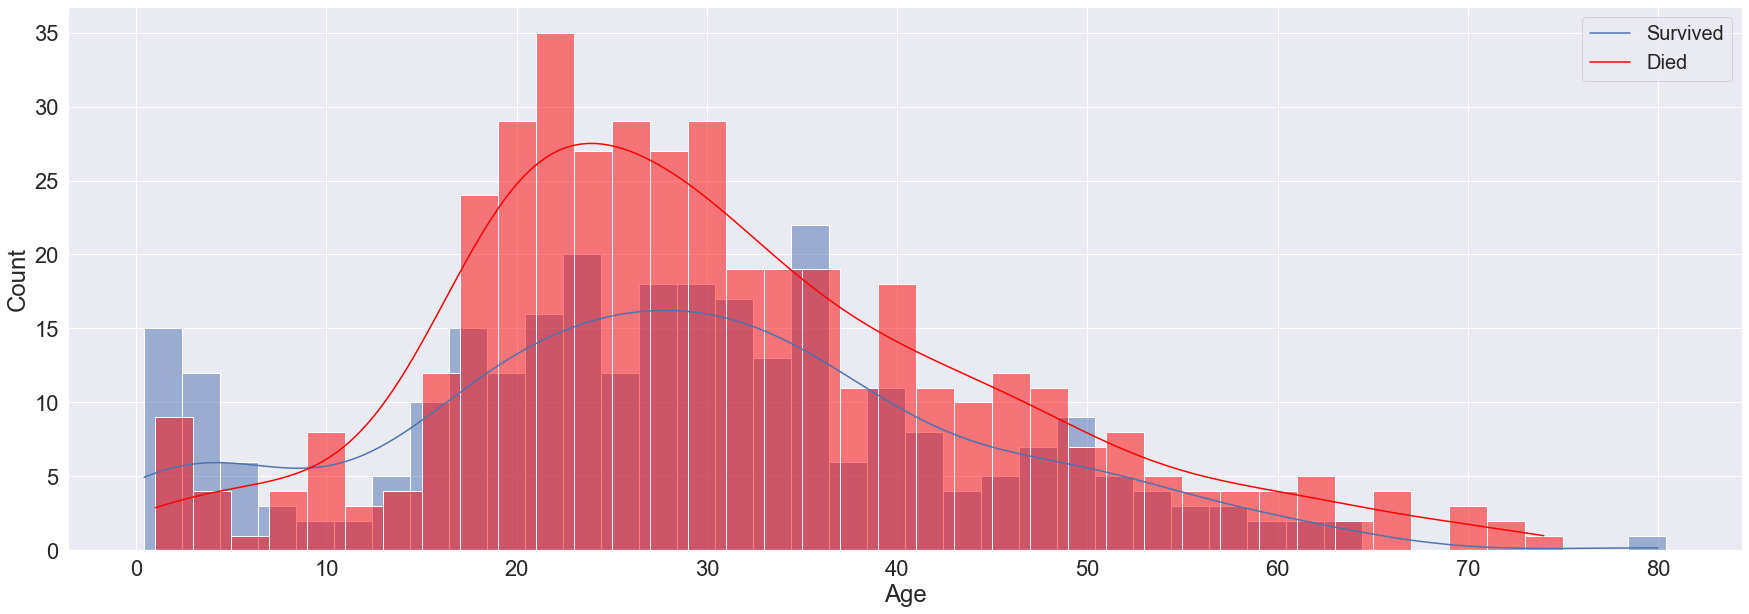

Missing age ratio among survived: 0.15
Missing age ratio among deceased: 0.23


In [467]:
sns.set(font_scale=2)
sns.histplot(data=titanic_df.loc[titanic_df['Survived'] == 1, 'Age'],\
             kde=True, legend=True, binwidth=2)
sns.histplot(data=titanic_df.loc[titanic_df['Survived'] == 0, 'Age'],\
             kde=True, color="red", binwidth=2)
plt.legend(labels=['Survived', 'Died'], prop={"size": 20})
plt.show()

print(f"Missing age ratio among \
survived: {titanic_df.loc[titanic_df['Survived'] == 1, 'Age'].isnull().sum()/len(titanic_df.loc[titanic_df['Survived'] == 1, 'Age']):.2f}")
print(f"Missing age ratio among \
deceased: {titanic_df.loc[titanic_df['Survived'] == 0, 'Age'].isnull().sum()/len(titanic_df.loc[titanic_df['Survived'] == 0, 'Age']):.2f}")

If we fill our missing data with mean or median value, we will destroy this relation. Looks like, if we have a person with NaN in "Age" column, his odds to survive might be lower.

The second observation is: minors have better chances to survive, than the adults. Therefore I will divide Age col in three classes: Minor, Adult and Missing.




In [468]:
minor = titanic_df['Age'] < 10
adult = titanic_df['Age'] >= 10
titanic_df.loc[minor, 'Age'] = 'minor'
titanic_df.loc[adult, 'Age'] = 'adult'
titanic_df['Age'].fillna('missing', inplace=True)

What about `Embarked`?

I am gonna fill missing data with the most popular port (Southampton). After that I will examine the `Cabin` data.

In [469]:
print(f"People embarked at \
Southampton: {titanic_df.loc[titanic_df['Embarked'] == 'S', 'Embarked'].count()}")
print(f"People embarked at \
Cherbourg: {titanic_df.loc[titanic_df['Embarked'] == 'C', 'Embarked'].count()}")
print(f"People embarked at \
Queenstown: {titanic_df.loc[titanic_df['Embarked'] == 'Q', 'Embarked'].count()}")
titanic_df["Embarked"].fillna('S', inplace=True)
print(f"{100 * titanic_df['Cabin'].isnull().sum()/len(titanic_df['Cabin']):.0f}% \
of the \"Cabin\" data is missing.")
print(f"We don't know the cabin number of \
{titanic_df.loc[titanic_df['Survived'] == 1, 'Cabin'].isnull().sum()/len(titanic_df.loc[titanic_df['Survived'] == 1, 'Cabin']):.2f}% of survived passengers.")
print(f"We don't know cabin number of \
{titanic_df.loc[titanic_df['Survived'] == 0, 'Cabin'].isnull().sum()/len(titanic_df.loc[titanic_df['Survived'] == 0, 'Cabin']):.2f}% of deceased passengers.")

People embarked at Southampton: 644
People embarked at Cherbourg: 168
People embarked at Queenstown: 77
77% of the "Cabin" data is missing.
We don't know the cabin number of 0.60% of survived passengers.
We don't know cabin number of 0.88% of deceased passengers.


So... `Cabin`. Looks like the vast majority of the data is missing and there is no significant difference between survived and deceased passengers.

I am not gonna use `Cabin`, `Ticket` and `Name` columns.

In [470]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
# features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
scaler = MinMaxScaler()

X = titanic_df[features].copy()
y = titanic_df['Survived'].copy()
y.columns = ['Survived']
X = pd.get_dummies(X, prefix=['Pclass', 'Sex', 'Embarked', 'Age'], columns=['Pclass', 'Sex', 'Embarked', 'Age'])
X.head(3)
X[["Fare"]] = scaler.fit_transform(X[["Fare"]])

`Survived` column mean value is less than 0.5. It means, there are more dead people in our dataset, than survived. We have to pay attention to the fact during our train-test splitting and use cross-validation.

I will start with linear_model library.

In [471]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

train_X, test_X, train_y, test_y =\
train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
model = SGDClassifier(random_state=1)
grid = {'alpha': [1e-11, 5e-7, 1e-6],
    'penalty': ['l2']}

gs = GridSearchCV(model, grid, scoring="precision", n_jobs=-1, cv=10,
                     return_train_score=True)

gs.fit(train_X, train_y)
predictions = gs.predict(test_X)

print(f"gridsearch best_score = {gs.best_score_:0.3f}")
print(f"gridsearch best parameters = {gs.best_params_}")
print(classification_report(test_y.values, predictions))
print(result.head())


gridsearch best_score = 0.806
gridsearch best parameters = {'alpha': 1e-11, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       110
           1       0.69      0.75      0.72        69

    accuracy                           0.78       179
   macro avg       0.76      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

     True  Predicted
232     0          0
54      0          0
277     0          0
385     0          0
75      0          0


In [474]:
from sklearn.ensemble import RandomForestClassifier

dt_model = RandomForestClassifier(random_state=1)
grid = {
    'max_leaf_nodes': [10, 11, 12, 13, 14, 15],
       }
gs = GridSearchCV(dt_model, grid, scoring="precision", n_jobs=-1, cv=10,
                     return_train_score=True)

gs.fit(train_X, train_y)
predictions = gs.predict(test_X)

print(f"gridsearch best_score = {gs.best_score_:0.3f}")
print(f"gridsearch best parameters = {gs.best_params_}")
print(classification_report(test_y.values, predictions))
print(result.head())

gridsearch best_score = 0.853
gridsearch best parameters = {'max_leaf_nodes': 12}
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       110
           1       0.88      0.72      0.79        69

    accuracy                           0.85       179
   macro avg       0.86      0.83      0.84       179
weighted avg       0.86      0.85      0.85       179

     True  Predicted
232     0          0
54      0          0
277     0          0
385     0          0
75      0          0


Final model.

In [475]:
fmodel = SGDClassifier(alpha=5e-07, penalty='l2', random_state=1)
fmodel.fit(X, y)
ftreemodel = DecisionTreeClassifier(max_leaf_nodes=8)
ftreemodel.fit(X, y)
rf_model = RandomForestClassifier(max_leaf_nodes=12)
rf_model.fit(X, y)
X.head(3)

,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_adult,Age_minor,Age_missing
0,0.014151,0,0,1,0,1,0,0,1,1,0,0
1,0.139136,1,0,0,1,0,1,0,0,1,0,0
2,0.015469,0,0,1,1,0,0,0,1,1,0,0


In [476]:
test_path = "test.csv"
test_df = pd.read_csv(test_path)

test_df['Fare'].fillna(14.45, inplace=True)

minor = test_df['Age'] < 10
adult = test_df['Age'] >= 10
test_df.loc[minor, 'Age'] = 'minor'
test_df.loc[adult, 'Age'] = 'adult'
test_df['Age'].fillna('missing', inplace=True)

t_X = test_df[features]
t_X = pd.get_dummies(t_X, prefix=['Pclass', 'Sex', 'Embarked', 'Age'], columns=['Pclass', 'Sex', 'Embarked', 'Age'])
t_X[['Fare']] = scaler.fit_transform(t_X[['Fare']])

In [477]:
t_predictions = ftreemodel.predict(t_X)
t_predictions = rf_model.predict(t_X)

In [478]:
submission = pd.DataFrame()
submission['PassengerId'] = test_df['PassengerId']
submission['Survived'] = t_predictions
submission.to_csv("randomforest_model__without_sibl_parch_submission.csv", index=False)